# Here I show implementation of the calculation of quantum price levels from Lee's 2020 Quantum Finance book.

We will use daily OHLCV data to calculate the quantum price levels for the next trading day for the s&p500 (SPY). <br>
For a more in-depth explanation of the calculation see chapters 3-5 in Lee's book.


In [1]:

# NOTEBOOK RAN ON 10-15-2023

# DEPENDENCIES

#!pip install plotly
#!pip install yfinance
#!pip install pandas
#!pip install numpy

# IMPORTS

from plotly.subplots import make_subplots

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import yfinance
import pandas
import numpy

# GATHER DATA FROM YAHOO FINANCE

#start_date = '2020-01-01'
#end_date = '2022-01-01'
ticker = 'SPY'

daily_stock_data = yfinance.download(ticker) # yf.download(ticker, start_date, end_date)

print(daily_stock_data)


[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1993-01-29   43.968750   43.968750   43.750000   43.937500   24.941395   
1993-02-01   43.968750   44.250000   43.968750   44.250000   25.118790   
1993-02-02   44.218750   44.375000   44.125000   44.343750   25.172007   
1993-02-03   44.406250   44.843750   44.375000   44.812500   25.438084   
1993-02-04   44.968750   45.093750   44.468750   45.000000   25.544531   
...                ...         ...         ...         ...         ...   
2023-10-09  427.579987  432.880005  427.010010  432.290009  432.290009   
2023-10-10  432.940002  437.220001  432.529999  434.540009  434.540009   
2023-10-11  435.640015  436.579987  433.179993  436.320007  436.320007   
2023-10-12  436.950012  437.339996  431.230011  433.660004  433.660004   
2023-10-13  435.209991  436.450012  429.880

Using relative return instead of price. <br>

$$r(t,\Delta t)=\frac{p(t)}{p(t-\Delta t)}$$ <br>
Where $\Delta t$ is the time difference between adjacent timestamps and $p(t)$ is the closing price at the end of the market day (4pm EST on date $t$). In our example, $\Delta t$ = 1 day.

In [2]:

daily_stock_data['r'] = daily_stock_data['Adj Close'] / daily_stock_data['Adj Close'].shift(1)
daily_stock_data = daily_stock_data.iloc[1:]

print(daily_stock_data['r'])


Date
1993-02-01    1.007112
1993-02-02    1.002119
1993-02-03    1.010570
1993-02-04    1.004185
1993-02-05    0.999305
                ...   
2023-10-09    1.006402
2023-10-10    1.005205
2023-10-11    1.004096
2023-10-12    0.993904
2023-10-13    0.995019
Name: r, Length: 7732, dtype: float64


Lee derieved an equation of motion by quantifying the effect of the major market participants and arrived at the schrodinger equation for an aharmonic oscillator. The eigenenergies are used as the quantum price levels. <br>

In efficient and stationary markets, the probability density $|\psi(r,t)|^2$ of price returns $r(t,\Delta t)$ should behave as a normal distribution. <br>

$$|\psi(r,t)|^2 = |\psi(r)|^2 = \rho (r)$$ <br>
Three things to note about $\rho (r)$: the data should fall into a normal distribution, the mean is close to one, and the ground state wave function $\psi(r)$ is symmetric around one.
We discard returns that are further away that 3 standard deviations ($3\sigma$) away from the mean. That means that the width $\Delta r$ of each bin we use for our probability density will be $\Delta r=\frac{2s\sigma}{b}$ where $b$ is the number of bins we have and $s$ is the number of standard deviations we allow the values of $r$ to be within. In our case, we use 100 bins which means $\Delta r=\frac{3\sigma}{50}$, and we use 2048 days as the lookback period as used in the book.

AVERAGE DAILY RETURN: 1.000527429429448
STANDARD DEVIATION OF DAILY RETURN: 0.01170594927536719


1.0188211986131748

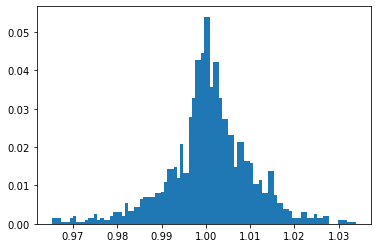

In [3]:

stds = 3
bins = 100
lookback = 2048
start = 2

# using the past 2048 days as in the book (for a different security)
past_observations = daily_stock_data['r'].iloc[-start-lookback:-start]

mean = past_observations.mean()
std = past_observations.std()

print('AVERAGE DAILY RETURN:', mean)
print('STANDARD DEVIATION OF DAILY RETURN:', std)

# exclude all returns higher than 3 standard deviations away from the mean
past_observations_in_range = past_observations[(past_observations-mean)**2 <= (stds*std)**2]

# group the returns in bins by their deviations away from the mean
# divide the number of occurrences in each bin by their sum
probability_density_array = pandas.cut(past_observations_in_range,bins=bins).value_counts(normalize=True,sort=False)

r_min = past_observations_in_range.min() # lowest return value in the array
r_max = past_observations_in_range.max() # highest return value in the array

r_scale = (bins - 1) / (r_max - r_min)

# group the returns in bins by their values
total_inliers = len(past_observations_in_range)
bin_indices = (r_scale * (past_observations_in_range - r_min)) // 1

dr = 2 * stds * std / bins

# group the returns in bins by their deviations away from the mean
drp1 = (r_scale * (mean + dr - r_min)) // 1
drm1 = (r_scale * (mean - dr - r_min)) // 1

# divide the number of occurrences in each bin by their sum
pp = (bin_indices == drp1).sum() / total_inliers
pm = (bin_indices == drm1).sum() / total_inliers

def p(r): # the probability density function
    
    r_0 = (r_scale * (r - r_min)) // 1
    
    return (bin_indices == r_0).sum() / total_inliers

x = numpy.arange(bins)/(bins-1) * (r_max - r_min) + r_min

plt.bar(x, numpy.vectorize(p)(x), 1.01 * (r_max - r_min) / (bins - 1)) # plot the probability density function

numpy.vectorize(p)(x).sum()


We will solve $\lambda$ in the quantum finance shrodinger equation (QFSE) derived in the book. <br>

$$\frac{d^2\psi (r)}{dr^2} \space + \space \left(r^2 \space + \space \lambda r^4\right ) \psi (r) = E\psi (r)$$ <br>

Let's consider two adjacent segments of the wave function $\psi (r + \Delta r)$ and $\psi (r - \Delta r)$. The kinetic energy terms (K.E.) for $\psi (r + \Delta r)$ and $\psi (r - \Delta r)$ each involve the second derivative of $\psi$ with respect to $r$ at $r + \Delta r$ and $r - \Delta r$ respectively. The book uses the symmetry properties of the ground state wavefunction to arive at the following equation for $\lambda$. <br>

$$\lambda = \left|\frac{(r - \Delta r)^2\psi (r - \Delta r) - (r + \Delta r)^2\psi (r + \Delta r)}{(r + \Delta r)^4\psi (r + \Delta r) - (r - \Delta r)^4\psi (r - \Delta r)}\right|$$

The polynomial below along with Cardano's Method for solving cubic equations will be used to evaluate the energy levels of the QFSE. This numerical solution was derived by [Dasgupta](https://iopscience.iop.org/article/10.1088/1751-8113/40/4/013) to evaluate the energies of Quantum Anharmonic Oscillators.

$$\left(\frac{E_n}{2n \space + \space 1}\right )^3 \space - \space \left(\frac{E_n}{2n \space + \space 1}\right ) \space - \space K_0^3\lambda = 0$$ <br>

$$K_0\approx\left[\frac{1.1924 \space + \space 33.2383n \space + \space 56.2169n^2}{1 \space + \space 43.6196n}\right]^{1/3}$$

Using $c_0 = -K_0^3\lambda$ and $c_1 = \sqrt{\frac{c_0^2}{4} \space - \space \frac{1}{27}}$, $E_n$ can be expressed as the equation below.

$$E_n = \left(2n \space + \space 1 \right)\left[\left(-\frac{c_0}{2} \space + \space c_1 \right)^{1/3} \space + \space \left(-\frac{c_0}{2} \space - \space c_1 \right)^{1/3}\right]$$ <br>

Our formula for quantum price levels is $Q_n$ where $P$ is chosen to be the last available daily closing price.

$$ Q_n=   \left\{
\begin{array}{ll}
      P\left(1 \space + \space \frac{0.21\sigma E_n}{E_0} \right) & n \ge 0 \\
      P\left(1 \space + \space \frac{0.21\sigma E_{-n}}{E_0} \right)^{-1} & n < 0 \\
\end{array} 
\right.  $$

**NOTE :** Based on the symmetry argument used in the book I would expect the equation for $\lambda$ to be the following... <br>

$$\lambda = \left|\frac{(r - \Delta r)^2 - (r + \Delta r)^2}{(r + \Delta r)^4 - (r - \Delta r)^4}\right|$$


In [4]:

k = lambda n : ((1.1924 + 33.2383*n + 56.2169*n*n) / (1 + 43.6196*n))**(1/3)
l = abs(((mean - dr)**2 * pm - (mean + dr)**2 * pp) / ((mean + dr)**4 * pp - (mean - dr)**4 * pm)) # lambda

C0 = -1.1924 * l
C1 = (C0**2 / 4 - 1 / 27)**0.5

E0 = (-C0/2 + C1)**(1/3) + (-C0/2 - C1)**(1/3)

def E(n):
    
    nn = n if n >= 0 else -n
    
    c0 = -k(nn)**3 * l
    c1 = (c0**2 / 4 - 1 / 27)**0.5
    
    E = (2 * nn + 1) * ((-c0 / 2 + c1)**(1/3) + (-c0 / 2 - c1)**(1/3)) / E0
    EE = 1 + std * 0.21 * E
    
    return EE if n >= 0 else 1 / EE
    
nqprs = numpy.vectorize(E)(numpy.arange(101)-50)


## Plot the 8 nearest price levels to the last 1-minute close on an intraday chart.

In [5]:

intraday_lookback = 1

intraday_stock_data = yfinance.download(ticker,interval='1m',start=daily_stock_data.index[-intraday_lookback],
                                        period=f'{intraday_lookback}d',prepost=True)


[*********************100%***********************]  1 of 1 completed


In [7]:

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('OHLC', 'Volume'),
                    row_width=[0.3, 0.7])

fig.add_trace(go.Candlestick(x=intraday_stock_data.index, open=intraday_stock_data['Open'],
                                     high=intraday_stock_data['High'], low=intraday_stock_data['Low'],
                                     close=intraday_stock_data['Close'], showlegend=False), row=1, col=1)

fig.add_trace(go.Bar(x=intraday_stock_data.index, y=intraday_stock_data['Volume'], showlegend=False), row=2, col=1)

fig.update_layout(title="Daily OHLCV", yaxis_title="Price (USD)", width=900, height=600)
fig.update(layout_xaxis_rangeslider_visible=False)

qpls = nqprs * daily_stock_data['Adj Close'].iloc[-intraday_lookback-1]
qpls = list(zip(list(((qpls-intraday_stock_data['Adj Close'].iloc[-1])**2)**0.5),list(qpls)))

qpls.sort()

rx = [intraday_stock_data.index[0],intraday_stock_data.index[-1]]

qplc = {'color':'rgba(64,64,255,0.5)'}

# plot the 8 closest qpls to the current intraday price
for i in qpls[:8]: fig.add_trace(go.Line(x=rx,y=2*[i[1]],showlegend=False,line=qplc),row=1,col=1)

fig.show()
